In [ ]:
import MDAnalysis as mda
from MDAnalysis.analysis import rms, align

import numpy as np

# to install pytraj, check https://amber-md.github.io/pytraj/latest/installation.html#from-conda-linux-ox
#import pytraj as pt

from matplotlib import pyplot as plt
%matplotlib inline

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})

import subprocess
import glob
import pandas as pd
import os


General settings

Reading all results files

In [ ]:
def generate_plots_mdanalysis(name,run,resultsdir,dataframedir):

    ##### PARM file

    parmfile='../inputs/'+name+'.parm7'
    print('parameter file:',parmfile)

    ##### TRAJECTORY FILES

    trajfiles = sorted(glob.glob(resultsdir+run+name+'_?.nc'))+sorted(glob.glob(resultsdir+run+name+'_??.nc'))
    print('trajectory files:',trajfiles)
      
    # some information
    u = mda.Universe(parmfile,trajfiles)
 
    print('Trajectory of run {0} contains {1} steps'.format(run,len(u.trajectory)))

    calc_RGYR(u,dataframedir,name)
    calc_RMSD(u,dataframedir,name)
    selection='name CA'
    nameRMSF=name+'_CA'
    calc_RMSF(u,parmfile,selection,dataframedir,nameRMSF)
    selection='name CG'
    nameRMSF=name+'_CG'
    calc_RMSF(u,parmfile,selection,dataframedir,nameRMSF)

def calc_RGYR(u,dataframedir,name):
    ######################
    # Radius of Gyration #
    ######################
    
    protein = u.select_atoms("protein")

    time = []
    rgyr = []
    for ts in u.trajectory:
        time.append(u.trajectory.time)
        rgyr.append(protein.radius_of_gyration())

    rgyr_df = pd.DataFrame(list(zip(time, rgyr)),
                columns =['Time (ps)', 'Radius of gyration (A)'],
                index=None)
    rgyr_df.to_csv(dataframedir+name+'RG.csv',index=False)

    x_name = rgyr_df.columns[0]
    y_name = rgyr_df.columns[1]
    x=rgyr_df[x_name]
    y=rgyr_df[y_name]

    ax = rgyr_df.plot(title=name+': Radius of gyration',x=x_name, y=y_name,kind='line')
    ax.set_ylabel(r'R$_g$ ($\AA$)')
    plt.savefig('../text/figures/'+name+'RG.png')


def calc_RMSD(u,dataframedir,name):
    ######################################
    # Root Mean Square Deviations (RMSD) #
    ######################################

    #u.trajectory[0] # set to first frame
    rmsd_analysis = rms.RMSD(u, select='backbone')
    rmsd_analysis.run()

    rmsd_df = pd.DataFrame(rmsd_analysis.results.rmsd,
                        columns=['Frame', 'Time (ps)', 'Backbone'])
    rmsd_df = rmsd_df[['Time (ps)', 'Backbone']]
    rmsd_df.to_csv(dataframedir+name+'RMSD.csv',index=False)

    ax = rmsd_df.plot(title=name+': RMSD',x='Time (ps)', y=['Backbone'],kind='line')
    ax.set_ylabel(r'RMSD ($\AA$)')
    plt.savefig('../text/figures/'+name+'RMSD.png')

def calc_RMSF(u,parmfile,selection,dataframedir,name):

    # https://userguide.mdanalysis.org/stable/examples/analysis/alignment_and_rms/rmsf.html

    #################################
    # Root Mean Square Fluctuations #
    #################################

    protein = u.select_atoms(selection)

    # Align the trajectory to the average structure
    average = align.AverageStructure(u, u, select='protein and name CA',
                                 ref_frame=0).run()
    ref = average.results.universe
    aligner=align.AlignTraj(u, ref, 
                            select='protein and name CA', 
                            filename='aligned.dcd',
                            in_memory=False).run()
    u2 = mda.Universe(parmfile,'aligned.dcd')

    # identify the subset of the trajectory you want to analyze
    # useful to leave out initial frames
    utraj = u2.trajectory[100:]

    # Calculate the average position of each atom
    average_positions = np.zeros_like(protein.positions)
    # n_frames = 0
    for ts in utraj:
        average_positions += protein.positions
        # n_frames += 1
    average_positions /= len(utraj)
    # average_positions /= n_frames

    # Calculate the RMSF
    rmsf = np.zeros(protein.n_atoms)
    for ts in utraj:
        rmsf += np.sum((protein.positions - average_positions)**2, axis=1)
        
    rmsf = np.sqrt(rmsf / len(utraj))
    # rmsf = np.sqrt(rmsf / n_frames)

    # Average the RMSF per residue
    residue_rmsf = []
    residue_ids = []

    for res in protein.residues:
        atom_indices_in_protein = []
    
        # Map global atom indices to local indices within the selection
        for atom in res.atoms:
           if atom.index in protein.indices:
                atom_indices_in_protein.append(protein.indices.tolist().index(atom.index))
    
        if len(atom_indices_in_protein) > 0:
            res_rmsf = rmsf[atom_indices_in_protein].mean()  # Average RMSF over all atoms in the residue
            residue_rmsf.append(res_rmsf)
            residue_ids.append(res.resid)  # Collect residue IDs

    # Convert the data to a pandas DataFrame
    rmsf_df = pd.DataFrame(list(zip(residue_ids, residue_rmsf)),
                columns= ['Residue ID','RMSF (A)'],
                index=None)


    # Save the DataFrame to a CSV file
    rmsf_df.to_csv(dataframedir+name+"RMSF.csv", index=False)

    x_name = rmsf_df.columns[0]
    y_name = rmsf_df.columns[1]
    x=rmsf_df[x_name]
    y=rmsf_df[y_name]

    ax = rmsf_df.plot(title=name+': RMSF',x=x_name, y=y_name,kind='line')
    ax.set_ylabel(r'RMSF ($\AA$)')
    plt.savefig('../text/figures/'+name+'RMSF.png')

    # # Finally, generate a PDB file with the RMSF info in the B-factor column
    # Note!!! this needs the MDAnalysis.analysis.rms.RMSF, so I have to modify this function 
    # u.add_TopologyAttr('tempfactors') # add empty attribute for all atoms
    # protein = u.select_atoms('protein') # select protein atoms
    # for residue, r_value in zip(protein.residues, R.results.rmsf):
    #     residue.atoms.tempfactors = r_value

In [ ]:
def generate_plots_mdout(name,run,resultsdir,dataframedir):

    ##### MDOUT files

    mdoutfiles = sorted(glob.glob(resultsdir+run+name+'_?.mdout'))+sorted(glob.glob(resultsdir+run+name+'_??.mdout'))
    print('MDOUT files:',mdoutfiles)

    ##### generate summary files from all mdout files
    pipe = subprocess.run(["process_mdout.perl"]+mdoutfiles,
                        check=True,
                        text=True,
                        capture_output=True)

    # assign dataset names
    data = {'DENSITY':r'$\rho$',
            'EKCMT':r'E_k CMT / kcal mol$^-1$',
            'EKTOT':r'E_k / kcal mol$-1$',
            'EPTOT':r'E_p / kcal mol$-1$',
            'ESCF':r'ESCF',
            'ETOT':r'E_tot / kcal mol$-1$',
            'PRES':r'PRESS',
            'TEMP':r'T / K',
            'TSOLUTE':r'T / K',
            'TSOLVENT':r'T / K',
            'VOLUME':r'V / $\AA^3$'}
 
    # create empty lists
    dataframes_list = []
    Ylabel_list = []
    Title_list = []

    # append datasets into the list
    for key, value in data.items():
        colnames=['Time (ps)',key]
        #print(colnames)
        temp_df = pd.read_csv("summary."+key,names=colnames,sep='\s+',index_col=None)
        if not temp_df.isnull().values.any():
            dataframes_list.append(temp_df)
            temp_df.to_csv(dataframedir+name+key+'.csv',index=False)
            Ylabel_list.append(value)
            Title_list.append(key)

    for i in range(len(dataframes_list)):
        dataframes_list[i].plot(x=colnames[0],y=Title_list[i])
        plt.ylabel(Ylabel_list[i])
        plt.title(name+': '+Title_list[i])
        plt.savefig('../text/figures/'+name+Title_list[i]+'.png')

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/jordivilla/miniconda3/envs/mdanalysis/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3550, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_16043/1147494843.py", line 16, in <module>
    generate_plots_mdanalysis(name,run,resultsdir,dataframedir)
  File "/tmp/ipykernel_16043/3643943418.py", line 25, in generate_plots_mdanalysis
    calc_RMSF(u,parmfile,selection,dataframedir,nameRMSF)
  File "/tmp/ipykernel_16043/3643943418.py", line 85, in calc_RMSF
    aligner=align.AlignTraj(u, ref,
  File "/home/jordivilla/miniconda3/envs/mdanalysis/lib/python3.9/site-packages/MDAnalysis/analysis/base.py", line 450, in run
    self._conclude()
  File "/home/jordivilla/miniconda3/envs/mdanalysis/lib/python3.9/site-packages/MDAnalysis/analysis/align.py", line 727, in _conclude
    self._writer.close()
  File "/home/jordivilla/miniconda3/envs/mdanalysis/lib/python3.9/site-packages/MDAnalysis/c

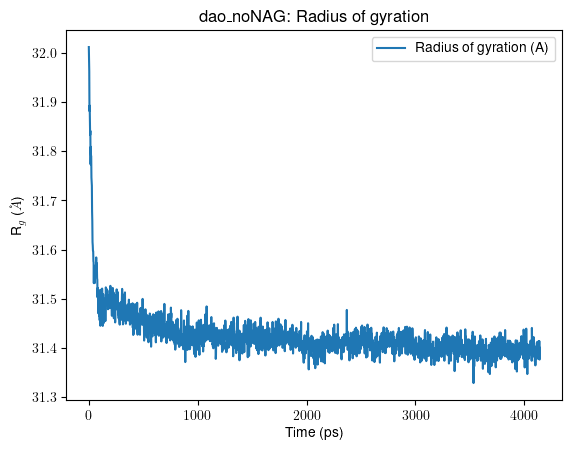

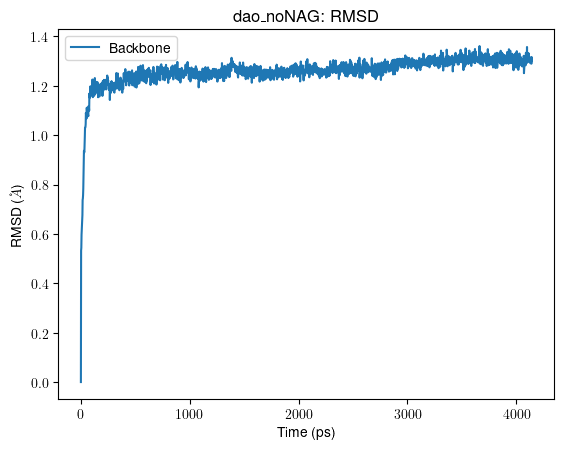

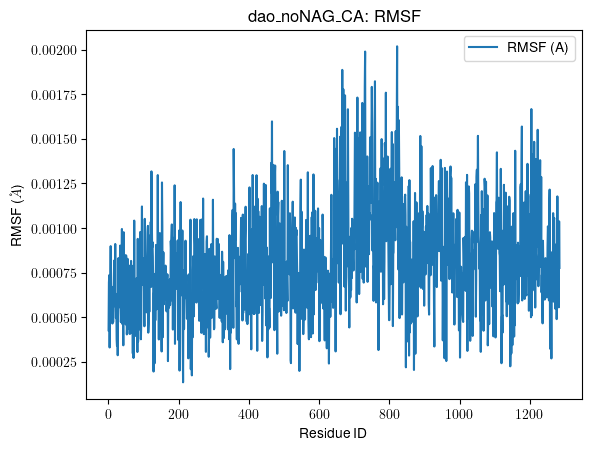

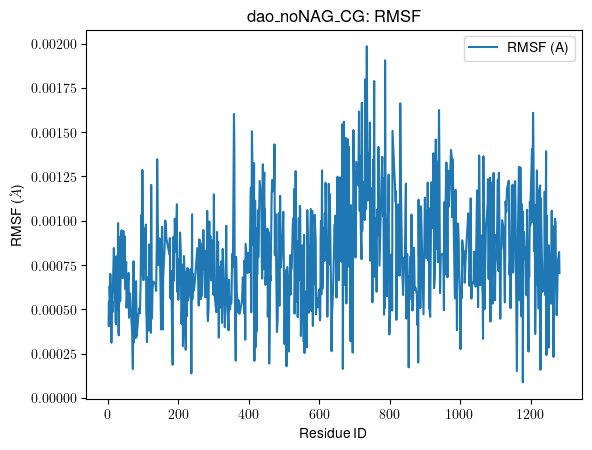

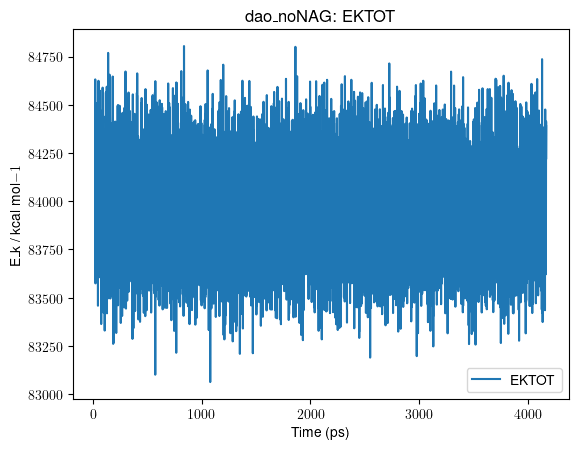

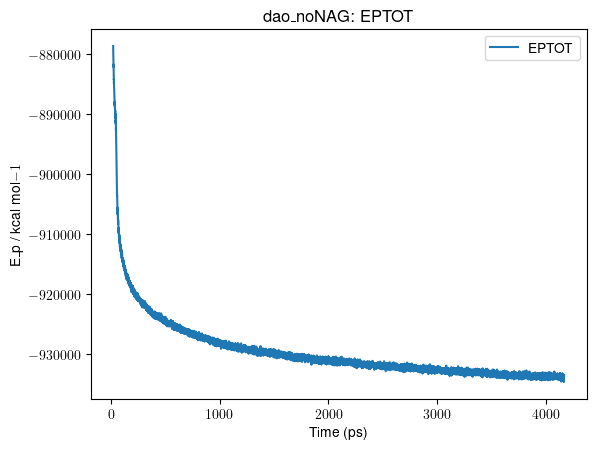

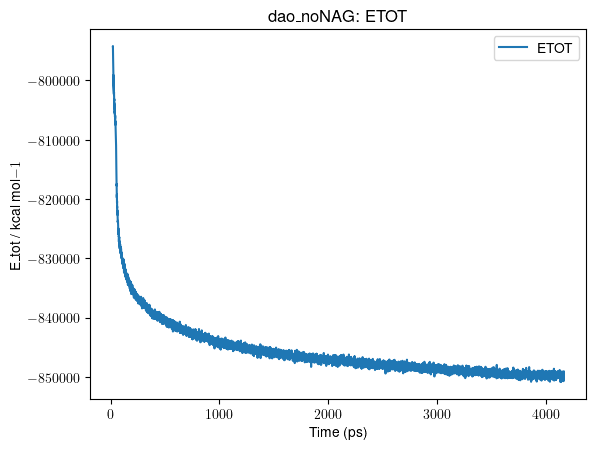

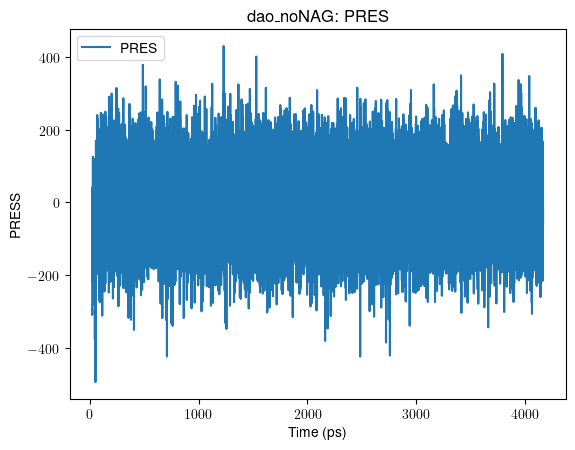

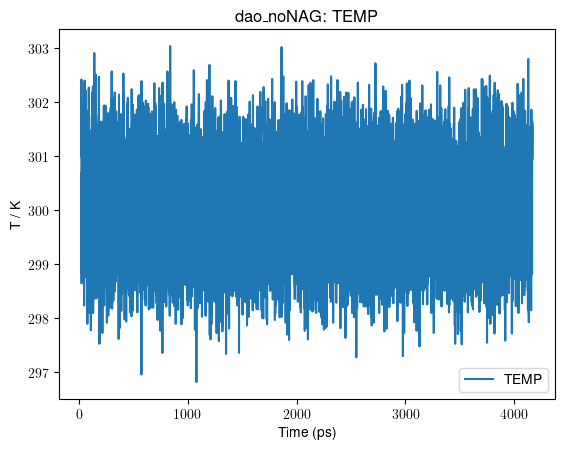

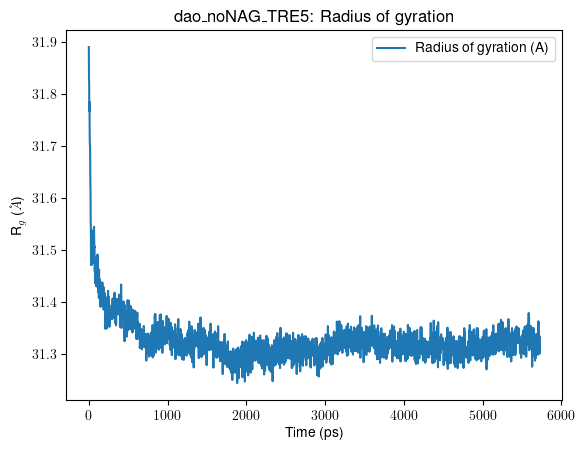

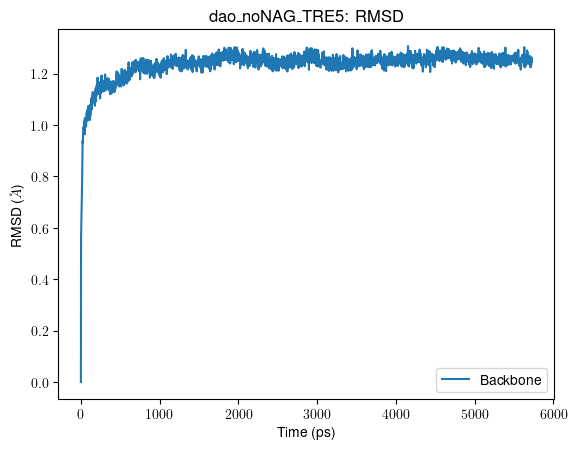

In [4]:
###### Name of the system to be analyzed
import sys
#resultsdir = os.environ['SCRATCHDIR']  
backupdir=os.environ['BACKUPFOLDER']
run='md'
dataframedir = './data/'
name,resultsdir='dao_noNAG',backupdir+'/*/'
generate_plots_mdanalysis(name,run,resultsdir,dataframedir)
generate_plots_mdout(name,run,resultsdir,dataframedir)

name,resultsdir='dao_noNAG_TRE5',backupdir+'/lapalma/'
generate_plots_mdanalysis(name,run,resultsdir,dataframedir)
generate_plots_mdout(name,run,resultsdir,dataframedir)

name,resultsdir='dao_noNAG_TRE25',backupdir+'/lapalma/'
generate_plots_mdanalysis(name,run,resultsdir,dataframedir)
generate_plots_mdout(name,run,resultsdir,dataframedir)

name,resultsdir='dao_noNAG_TRE100',backupdir+'/lapalma/'
generate_plots_mdanalysis(name,run,resultsdir,dataframedir)
generate_plots_mdout(name,run,resultsdir,dataframedir)

name,resultsdir='dao_noNAG_TRE250',backupdir+'/lapalma/'
generate_plots_mdanalysis(name,run,resultsdir,dataframedir)
generate_plots_mdout(name,run,resultsdir,dataframedir)

name,resultsdir='dao_noNAG_TRE500',backupdir+'/lapalma/'
generate_plots_mdanalysis(name,run,resultsdir,dataframedir)
generate_plots_mdout(name,run,resultsdir,dataframedir)
